# Make plots for GAM predictions generated in R

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from settings_general import channel_name_dict
from shared.helper_functions import select_folder, save_figure

Change plot theme

In [3]:
sns.set_theme()

Define palette

In [4]:
palette = {'DRD2-WT': '#419D78', 'DRD2-KO': '#EB5E55'}

### Function definition

In [7]:
def parse_summary_significance(text_filepath, header_line = 'freqs window(s) of significant difference(s):\n', end_line = "Summary:\n"):
    """
        Parser for getting significance windows from model report
    """
    
    with open(text_filepath, "r") as f:
        summary = f.readlines()

    # Find header line index
    try:  # if there is no header line, then there are no significant differences
        header_idx = summary.index(header_line)
    except ValueError:
        return pd.DataFrame({})
    
    # find line to stop at
    count = 0
    end_idx = None

    # there are two 'Summary:\n' occurrences, let's find the second
    for i, item in enumerate(summary):
        # Check if the current item is equal to end_line
        if item == end_line:
            # Increment the count of occurrences
            count += 1
            # If it's the second occurrence, store its index and break the loop
            if count == 2:
                end_idx = i
                break

    # Extract the lines containing session_bin windows
    freq_lines = summary[header_idx + 1:end_idx]

    # Extract the numbers from the lines
    numbers = [re.findall(r'([\d.]+)', line) for line in freq_lines]
    return pd.DataFrame(numbers, columns=['from_freq', 'to_freq']).apply(pd.to_numeric)

### Loop model results and plot modeled data

In [9]:
model_results_path = select_folder("Select the folder holding the GAM model output files (summaries & predictions) for this experiment")

In [10]:
plots_folder = select_folder("Select the folder you wish to save plots to")

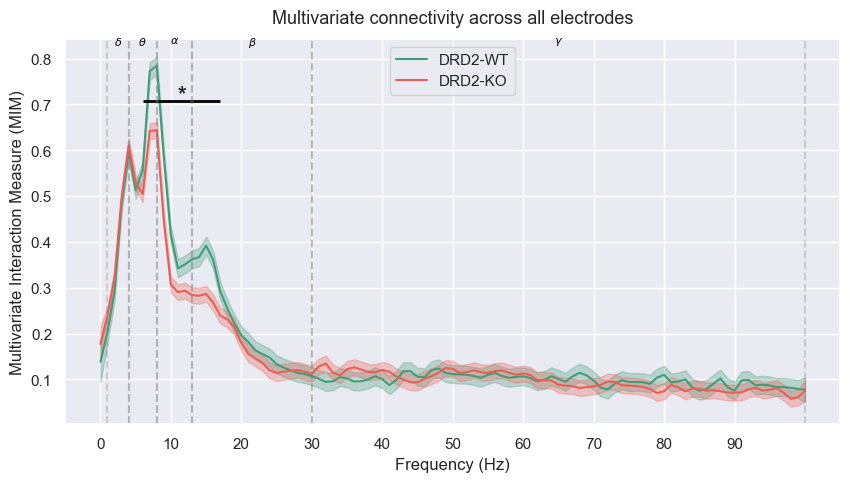

In [58]:
from settings_general import freq_bands_eeg

pred_path = f"{model_results_path}/pred_resting_state_rest.xlsx"
summary_path = f"{model_results_path}/summary_resting_state_rest.txt"

df = pd.read_excel(pred_path)
sig_win = parse_summary_significance(summary_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

genotype = df['genotype'].unique()
    
# loop through genotypes
for i, genotype in enumerate(genotype):
    # get the genotype data
    df_sub = df[df['genotype'] == genotype]
    # plot the line
    ax.plot(df_sub['freqs'], df_sub['fit'], color=palette[genotype], label=genotype)
    ax.fill_between(df_sub['freqs'], df_sub['fit'] + df_sub['CI'], df_sub['fit'] - df_sub['CI'], color=palette[genotype], alpha=0.3)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Multivariate Interaction Measure (MIM)')
ax.set_title('Multivariate connectivity across all electrodes', fontsize=13, y=1.02)
ax.legend(loc='best')

ymin = ax.get_ylim()[0]
ymax = df_sub['fit'].max() + 0.1 * df_sub['fit'].max()
for window in sig_win.itertuples():
    ax.text(np.floor((window.from_freq + window.to_freq) / 2), ymax, '*', fontweight='bold', fontsize=16)
    ax.hlines(ymax, xmin=window.from_freq, xmax=window.to_freq, color='black', linewidth=2)
    
for band, (start, end) in freq_bands_eeg.items():
    ax.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    ax.text((start + end) / 2, ax.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

save_figure(os.path.join(plots_folder, "gam_plot_all_electrodes.pdf"))

And now, a GAM fitted on the electrodes that belong to the DMN

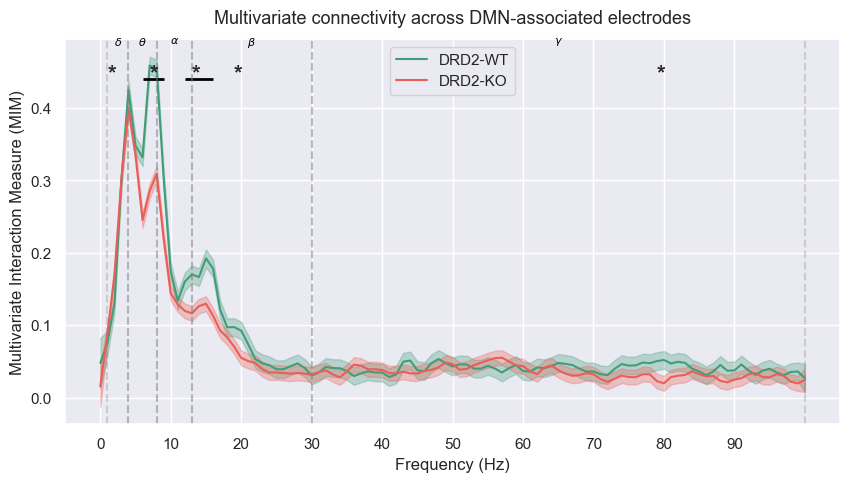

In [59]:
from settings_general import freq_bands_eeg

pred_path = f"{model_results_path}/pred_resting_state_rest_DMN.xlsx"
summary_path = f"{model_results_path}/summary_resting_state_rest_DMN.txt"

df = pd.read_excel(pred_path)
sig_win = parse_summary_significance(summary_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

genotype = df['genotype'].unique()
    
# loop through genotypes
for i, genotype in enumerate(genotype):
    # get the genotype data
    df_sub = df[df['genotype'] == genotype]
    # plot the line
    ax.plot(df_sub['freqs'], df_sub['fit'], color=palette[genotype], label=genotype)
    ax.fill_between(df_sub['freqs'], df_sub['fit'] + df_sub['CI'], df_sub['fit'] - df_sub['CI'], color=palette[genotype], alpha=0.3)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Multivariate Interaction Measure (MIM)')
ax.set_title('Multivariate connectivity across DMN-associated electrodes', fontsize=13, y=1.02)
ax.legend(loc='best')

ymin = ax.get_ylim()[0]
ymax = df_sub['fit'].max() + 0.1 * df_sub['fit'].max()
for window in sig_win.itertuples():
    ax.text(np.floor((window.from_freq + window.to_freq) / 2), ymax, '*', fontweight='bold', fontsize=16)
    ax.hlines(ymax, xmin=window.from_freq, xmax=window.to_freq, color='black', linewidth=2)
    
for band, (start, end) in freq_bands_eeg.items():
    ax.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    ax.text((start + end) / 2, ax.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

save_figure(os.path.join(plots_folder, "gam_plot_all_electrodes_DMN.pdf"))